Next steps:
- Follow [supervised learning](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/)
- Follow [unsupervised learning](https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/)

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import pandas as pd

In [28]:
# Load data

from seattlecycling.data import get_fremont_data
data = get_fremont_data()
data = data.loc['1 Oct 2012':'14 May 2014']
data.head()

,Total,West,East
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,2.0,3.0
2012-10-03 04:00:00,7.0,6.0,1.0


In [29]:
# Resample data into daily and weekly totals

daily = data.resample('d').sum()
weekly = data.resample('w').sum()

A first peak at the data

Text(0, 0.5, 'Weekly rides')

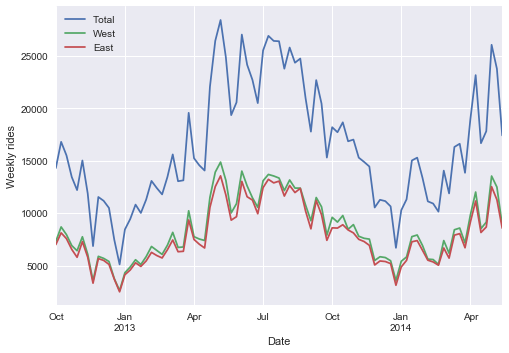

In [30]:
weekly.plot();
plt.ylabel('Weekly rides')

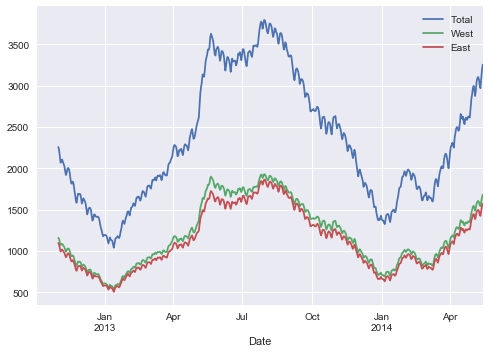

In [34]:
# Look at rolling weekly mean to smooth out short-term variation

data.resample('d').sum().rolling(30).mean().plot();

Blog port points out that 2014 has seen increased cycle traffic across the bridge. Below we're modelling seasonal variation based on what we think influences peoples' decision whether or not to ride a bike.

In [35]:
from seattlecycling.tools import hours_of_daylight

In [38]:
weekly['daylight'] = map(hours_of_daylight, weekly.index)

In [39]:
weekly.head()

,Total,West,East,daylight
Date,,,,
2012-10-07,14292.0,7297.0,6995.0,<map object at 0x115184f50>
2012-10-14,16795.0,8679.0,8116.0,<map object at 0x115184f50>
2012-10-21,15509.0,7946.0,7563.0,<map object at 0x115184f50>
2012-10-28,13437.0,6901.0,6536.0,<map object at 0x115184f50>
2012-11-04,12194.0,6408.0,5786.0,<map object at 0x115184f50>


In [41]:
hours_of_daylight(2010-10-12)

TypeError: unsupported operand type(s) for -: 'int' and 'datetime.datetime'